# SFSNet paper implementation
### Introduction
SfSNet,  an  end-to-end  learning  frameworkfor  producing  an  accurate  decomposition  of  an  uncon-strained human face image into shape, reflectance and illu-minance. SfSNet is designed to reflect a physical lambertianrendering model.  SfSNet learns from a mixture of labeled synthetic  and  unlabeled  real  world  images. This is an implementation of the paper which can e found here , https://arxiv.org/pdf/1712.01261.pdf \
**Note** : It is recomended to read this notebook simultaneously with the paper to get more clarity


In [28]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets,transforms

In [2]:
device=torch.device('cuda')

### Loading the datasets
As shown above , after importing the essential packages we initialise torch to work with cuda capable GPUs.
The cells below augments the dataests and loads them in te form of pytorch DataLoaders object. Onnly the light data which is in the form of spherical harmonics is loaded into single tensor and then split into the batch size

In [3]:
Transforms=transforms.Compose([transforms.Resize((128,128)),
                              transforms.ToTensor()])
folder=datasets.ImageFolder("/home/home/Downloads/archive/img_align_celeba/",Transforms)
real_images=torch.utils.data.DataLoader(dataset=folder,batch_size=32)

In [4]:
albedo_folder=datasets.ImageFolder("/home/home/Desktop/SfsNet/NetworkModel/datasets/albedo",Transforms)
depth_folder=datasets.ImageFolder("/home/home/Desktop/SfsNet/NetworkModel/datasets/depth",Transforms)
normal_folder=datasets.ImageFolder("/home/home/Desktop/SfsNet/NetworkModel/datasets/normals",Transforms)
face_folder=datasets.ImageFolder("/home/home/Desktop/SfsNet/NetworkModel/datasets/faces",Transforms)
mask_folder=datasets.ImageFolder("/home/home/Desktop/SfsNet/NetworkModel/datasets/masks",Transforms)


In [5]:
albedo=torch.utils.data.DataLoader(dataset=albedo_folder,batch_size=8)
depth=torch.utils.data.DataLoader(dataset=depth_folder,batch_size=8)
normal=torch.utils.data.DataLoader(dataset=normal_folder,batch_size=8)
face=torch.utils.data.DataLoader(dataset=face_folder,batch_size=8)
mask=torch.utils.data.DataLoader(dataset=mask_folder,batch_size=8)

In [6]:
light="/home/home/Desktop/SfsNet/NetworkModel/datasets/lighting/lighting/"
x=os.listdir(light)
z=np.empty((0,27))
for f in sorted(x):
    with open(light+"/"+f,"r") as log:
        z=np.append(z,[np.loadtxt(light+"/"+f)],axis=0)
lighting=torch.from_numpy(z)


In [7]:
light=torch.split(lighting,8,dim=0)
l=next(iter(light))
len(light)

94

## SfSNet Neural network implementation
### The Residual block

In [8]:
class ResBlocks(torch.nn.Module):
    def __init__(self,in_dim,out_dim,stride=1):
        super().__init__()
        self.res=torch.nn.Sequential(torch.nn.BatchNorm2d(in_dim),
                                     torch.nn.ReLU(inplace=True),
                                     torch.nn.Conv2d(in_dim, in_dim, 3, stride=1, padding=1),
                                     torch.nn.BatchNorm2d(in_dim),
                                     torch.nn.ReLU(inplace=True),
                                     torch.nn.Conv2d(in_dim, out_dim, 3, stride=1, padding=1))
    def forward(self,x):
        residue=x
        out=self.res(x)
        out=out+residue
        return out

### The Normal Residual Block
The normal block utilises five layers of the Residual Block defined above.

In [9]:
class NormalBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = ResBlocks(128, 128)
        self.block2 = ResBlocks(128, 128)
        self.block3 = ResBlocks(128, 128)
        self.block4 = ResBlocks(128, 128)
        self.block5 = ResBlocks(128, 128)
        self.bn1    = torch.nn.BatchNorm2d(128)
    def forward(self,x):
        l1=self.block1.forward(x)
        l2=self.block2.forward(l1)
        l3=self.block3.forward(l2)
        l4=self.block4.forward(l3)
        l5=self.block5.forward(l4)
        l6=torch.nn.ReLU()(self.bn1(l5))
        return l6
        

###  The Albedo residual Block
The albedo block utilises five layers of the Residual Block defined above, just like Normal Residual block but their weights are not shared.

In [10]:
class AlbedoBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = ResBlocks(128, 128)
        self.block2 = ResBlocks(128, 128)
        self.block3 = ResBlocks(128, 128)
        self.block4 = ResBlocks(128, 128)
        self.block5 = ResBlocks(128, 128)
        self.bn1    = torch.nn.BatchNorm2d(128)
    def forward(self,x):
        l1=self.block1.forward(x)
        l2=self.block2.forward(l1)
        l3=self.block3.forward(l2)
        l4=self.block4.forward(l3)
        l5=self.block5.forward(l4)
        l6=torch.nn.ReLU()(self.bn1(l5))
        return l6

###  The Encoder or Base Extractor
This is the encoder neural network which extracts features from the source image to e fed further to the normal,albedo and light estimator networks

In [11]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net=torch.nn.Sequential(torch.nn.Conv2d(3,64,7,stride=1,padding=3),
                                    torch.nn.BatchNorm2d(64),
                                    torch.nn.ReLU(),
                                    torch.nn.Conv2d(64,128,3,stride=1,padding=1),
                                    torch.nn.BatchNorm2d(128),
                                    torch.nn.ReLU(),
                                    torch.nn.Conv2d(128,128,3,stride=2,padding=1))
    def forward(self,x):
        l1= self.net(x)
        return l1

### The Normal Decoder
This network takes input from the normal residual block  and gives a normal map as its output

In [12]:
class NormalNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net=torch.nn.Sequential(torch.nn.Upsample(scale_factor=2, mode='bilinear'),
                                    torch.nn.Conv2d(128,128,1,stride=1),
                                    torch.nn.BatchNorm2d(128),
                                    torch.nn.ReLU(),
                                    torch.nn.Conv2d(128,64,3,padding=1),
                                    torch.nn.BatchNorm2d(64),
                                    torch.nn.ReLU(),
                                    torch.nn.Conv2d(64, 3, kernel_size=1))

    def forward(self, x):
        l1=self.net(x)
        return l1

###  The Albedo Decoder
This network takes input from the albedo residual block  and gives a albedo map as its output \
*Note* : Weights are not shared between this and the normal decoder.

In [13]:
class AlbedoNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net=torch.nn.Sequential(torch.nn.Upsample(scale_factor=2, mode='bilinear'),
                                    torch.nn.Conv2d(128,128,1,stride=1),
                                    torch.nn.BatchNorm2d(128),
                                    torch.nn.ReLU(),
                                    torch.nn.Conv2d(128,64,3,padding=1),
                                    torch.nn.BatchNorm2d(64),
                                    torch.nn.ReLU(),
                                    torch.nn.Conv2d(64, 3, kernel_size=1))

    def forward(self, x):
        l1=self.net(x)
        return l1

### The Light Estimator
Though it iscalled a light estimator but its output is a 27 dimensional spherical harmonics tensor.\
The input to this network is a concatenated tensor of the output of encoder, normal residual block and the albedo residual block.

In [14]:
class LightEstimation(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net=torch.nn.Sequential(torch.nn.Conv2d(384,128,1,stride=1),
                                    torch.nn.BatchNorm2d(128),
                                    torch.nn.ReLU(),
                                    torch.nn.AvgPool2d(64, stride=1,padding=0))
        self.fc2=torch.nn.Linear(128, 27)

    def forward(self, x):
        l1=self.net(x)
        l2=l1.view(-1,128)
        out=self.fc2(l2)
        return out

### The SfS Neural netwok
The neural-net defined below is the main neural-net which is a combination of all the neural-net mentioned above.
The way the above Nets are combined is defined in the paper as per Appendix 8.1

In [15]:
class SfS(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ec=Encoder()
        self.a=AlbedoBlock()
        self.n=NormalBlock()
        self.nl=NormalNet()
        self.al=AlbedoNet()
        self.l=LightEstimation()
    def forward(self,x):
        l1=self.ec.forward(x)
        l2=self.a.forward(l1)
        l3=self.n.forward(l1)
        l4=self.nl.forward(l3)
        l5=self.al.forward(l2)
        tog=torch.cat((l1,l2,l3),dim=1)
        l6=self.l.forward(tog)
        return l4,l5,l6
        

## Training and testing
### Loading the optimizer and loss criterions
We now load  the network and define the optimizer and loss functions. The loss functions for the different network is defined as per the paper. The L2Loss which is to predict the spherical harmonics from the light estimator is none other than mean squared error loss. \
**Note** - As the paper does not specify any particualr loss function I am using Adam with a learning rate of 0.001

In [16]:
network=SfS().to(device)
normal_criterion=torch.nn.L1Loss()
albedo_criterion=torch.nn.L1Loss()
light_criterion=torch.nn.MSELoss()

optimizer=torch.optim.Adam(params=network.parameters(),lr=0.001)

In [17]:
def get_shading(N, L):
    C1 = 0.8862269254527579
    C2 = 1.0233267079464883
    C3 = 0.24770795610037571
    C4 = 0.8580855308097834
    C5 = 0.4290427654048917

    nx = N[:, 0, :, :]
    ny = N[:, 1, :, :]
    nz = N[:, 2, :, :]
    
    b, c, h, w = N.shape
    
    Y1 = C1 * torch.ones(b, h, w)
    Y2 = C2 * nz
    Y3 = C2 * nx
    Y4 = C2 * ny
    Y5 = C3 * (2 * nz * nz - nx * nx - ny * ny)
    Y6 = C4 * nx * nz
    Y7 = C4 * ny * nz
    Y8 = C5 * (nx * nx - ny * ny)
    Y9 = C4 * nx * ny

    L = L.type(torch.float)
    sh = torch.split(L, 9, dim=1)
    
    shading = torch.zeros(b, c, h, w)
    
    if torch.cuda.is_available():
        Y1 = Y1.cuda()
        shading = shading.cuda() 
    
    for j in range(c):
        l = sh[j]
        l = l.repeat(1, h*w).view(b, h, w, 9)
        l = l.permute([0, 3, 1, 2])
        shading[:, j, :, :] = Y1 * l[:, 0] + Y2 * l[:, 1] + Y3 * l[:, 2] + \
                            Y4 * l[:, 3] + Y5 * l[:, 4] + Y6 * l[:, 5] + \
                            Y7 * l[:, 6] + Y8 * l[:, 7] + Y9 * l[:, 8]
        

    return shading

### Training the SfsNet as a Skip-Net
Now we start the training of the SfSnet as SkipNet on labeled synthetic data. \
The main idea behind this training is to train the network to identify and learn to predict normal maps, albedos and spherical harmonics for light data .The details for this are mentioned in section 3.1 of te paper.

In [28]:
epochs=20
for e in range(epochs):
    loss=0
    for a,n,f,l in zip(albedo,normal,face,light):
        al=a[0].to(device)
        nl=n[0].to(device)
        fa=f[0].to(device)
        li=l.to(device)
        optimizer.zero_grad()
        normal_map,albedo_map,light_data=network.forward(fa)
        normal_loss=normal_criterion(normal_map,nl)
        albedo_loss=normal_criterion(albedo_map,al)
        light_loss=normal_criterion(light_data,li)
        total_loss=normal_loss+albedo_loss+light_loss
        loss=total_loss.item()
        total_loss.backward()
        optimizer.step()
        del al
        del nl
        del fa
        del li
        torch.cuda.empty_cache()
    print("Loss after ",e," epochs is ",loss)
        
    

Loss after  0  epochs is  0.05221759095952383
Loss after  1  epochs is  0.06641651508624696
Loss after  2  epochs is  0.06023808166732442
Loss after  3  epochs is  0.053205808493569574
Loss after  4  epochs is  0.05924793834514312
Loss after  5  epochs is  0.05679329307299748
Loss after  6  epochs is  0.05623074935411831
Loss after  7  epochs is  0.06520078772817929
Loss after  8  epochs is  0.055936239013783015
Loss after  9  epochs is  0.05101555837732941
Loss after  10  epochs is  0.05484142638845502
Loss after  11  epochs is  0.04566387105592684
Loss after  12  epochs is  0.05967515272613717
Loss after  13  epochs is  0.056572989186631645
Loss after  14  epochs is  0.05468726722818988
Loss after  15  epochs is  0.054374016514044846
Loss after  16  epochs is  0.0472295219058195
Loss after  17  epochs is  0.05374555379395926
Loss after  18  epochs is  0.049275781539615746
Loss after  19  epochs is  0.06443774855867937


In [84]:
torch.save(network.state_dict(),'SfsSuper.pt')

### Training the complete SfSNet
After training the data as a Skip-Net we load the trained model and train it again in a pseudo -supervised manner
and we introduce the reconstruction loss here.The reconstruction is achieved by multiplying the shading maps with albedos, which is compared against the real image to learn.

In [26]:
recon_criterion=torch.nn.L1Loss()
main_network=SfS().to(device)
main_network.load_state_dict(torch.load('SfsSuper.pt'))
optimizer=torch.optim.Adam(params=main_network.parameters(),lr=0.01)

In [27]:
epochs=5
lambda_recon  = 0.5
lambda_albedo = 0.5
lambda_normal = 0.5
lambda_sh     = 0.1
for e in range(epochs):
    loss=0
    for a,n,f,l in zip(albedo,normal,face,light):
        al=a[0].to(device)
        nl=n[0].to(device)
        fa=f[0].to(device)
        li=l.to(device)
        optimizer.zero_grad()
        normal_map,albedo_map,light_data=main_network.forward(fa)
        
        s=get_shading(normal_map,light_data)
        recon=s*albedo_map
        
        normal_loss=normal_criterion(normal_map,nl)
        albedo_loss=normal_criterion(albedo_map,al)
        light_loss=normal_criterion(light_data,li)
        recon_loss=recon_criterion(recon,fa)
        total_loss=lambda_normal*normal_loss+lambda_albedo*albedo_loss+lambda_sh*light_loss+lambda_recon*recon_loss
        loss=total_loss.item()
        total_loss.backward()
        optimizer.step()
        del al
        del nl
        del fa
        del li
        del s
        del recon
        torch.cuda.empty_cache()
    print("Loss after ",e," epochs is ",loss)

Loss after  0  epochs is  0.20392436750464898
Loss after  1  epochs is  0.1977594520398627
Loss after  2  epochs is  0.18334796993135216
Loss after  3  epochs is  0.18310839171533094
Loss after  4  epochs is  0.17272049448095086


### Sample tests
Below are some of the random tests for the trained SfSNet model.

In [24]:
torch.save(main_network.state_dict(),'SfSNet.pt')

In [88]:
image,_=next(iter(face))
tester=SfS().to(device)
tester.load_state_dict(torch.load('SfsSuper.pt'))

<All keys matched successfully>

In [89]:
img=image.to(device)
with torch.no_grad():
    norm,alb,lite=tester.forward(img)

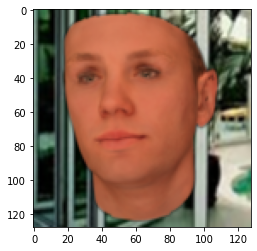

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


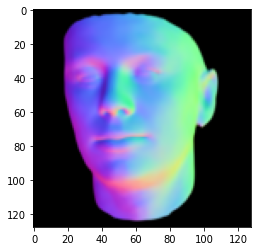

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


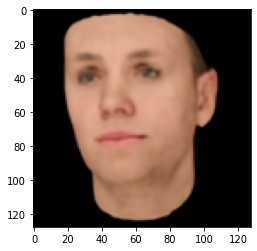

In [90]:
n=norm.cpu()
a=alb.cpu()
sh=lite.cpu()
plt.imshow(image[2].detach().permute(1,2,0))
plt.show()
plt.imshow(n[2].detach().permute(1,2,0))
plt.show()
plt.imshow(a[2].detach().permute(1,2,0))

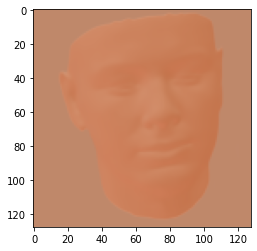

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 128, 128])

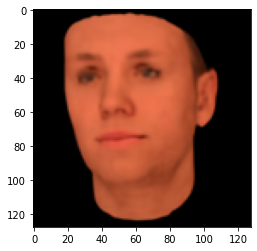

In [93]:
s=get_shading(norm,lite)
s=s.cpu()
recon=s*a
plt.imshow(s[5].detach().permute(1,2,0))
plt.show()
plt.imshow(recon[2].detach().permute(1,2,0))
recon.shape

In [77]:
del img
del tester
torch.cuda.empty_cache()

NameError: name 'img' is not defined

In [20]:
!nvidia-smi

Sat Nov  7 04:12:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  On   | 00000000:01:00.0  On |                  N/A |
| 21%   45C    P0    N/A /  75W |   2645MiB /  4038MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()